# Iris Classification
This notebook does some EDA, then applies a Decision Tree and Random Forest to the Iris dataset of flowers, one of scikit-learn's built in datasets

In [6]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from operator import itemgetter
%matplotlib inline

In [4]:
data = load_iris()
#Load features (150x4 array) and target (150x1 array)
features = data['data']
feature_names = data['feature_names']
target = data['target']
target_names = data['target_names']

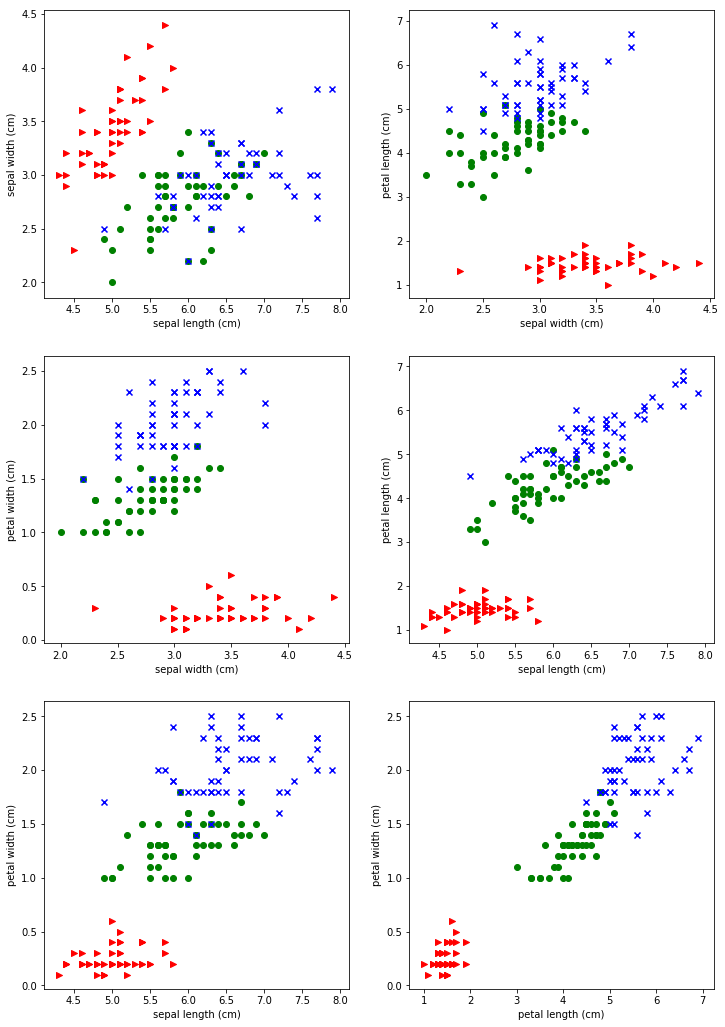

In [32]:
#Function to plot features as scatter for understanding the data
def iris_scatter(xfeatures,yfeatures,rows,cols,markers,colours,subplot_width,subplot_height):
    
    iris_types = 3 #3 types of flower in the data
    
    #Check arguments passed
    for xfeat in xfeatures:
        assert xfeat in range(len(features[0])), 'One or more plot x features not in range'
    for yfeat in yfeatures:
        assert yfeat in range(len(features[0])), 'One or more plot y features not in range'
    assert len(markers)==iris_types, 'Incorrect number of markers'
    assert len(colours)==iris_types, 'Incorrect number of colours'
    
    fig, axes = plt.subplots(rows,cols,figsize=(subplot_width*cols,subplot_height*rows))
    target_types = range(iris_types)
    subplot_rows = list(range(rows))*cols
    subplot_columns = list(range(cols))*rows
    
    def iris_subplot(subplot_row,subplot_col,xfeat,yfeat):
        #For each of the target types (flower types)
        ax = axes[subplot_row,subplot_col]
        for target_type,marker,colour in zip(target_types,markers,colours):
            ax.scatter(features[target==target_type,xfeat],features[target==target_type,yfeat],\
                                                  marker=marker,c=colour)
            ax.set_xlabel(feature_names[xfeat])
            ax.set_ylabel(feature_names[yfeat])

    for subplot_row, subplot_col, xfeat, yfeat in zip(subplot_rows,subplot_columns,xfeatures,yfeatures):
        iris_subplot(subplot_row, subplot_col, xfeat, yfeat)

iris_scatter(xfeatures = [0,0,0,1,1,2],
             yfeatures = [1,2,3,2,3,3],
             rows=3,
             cols=2,
             markers = ">ox",
             colours = "rgb",
             subplot_width=6,
             subplot_height=6)

## Decision Tree
In this section we build and tune a decision tree to classify seeds before moving on to Random Forest tuning. First we construct a naive classifier as our performance baseline.

In [13]:
nveclf = DecisionTreeClassifier()
nveclf = nveclf.fit(features,target)
scores = cross_validate(nveclf,X=features,y=target,cv=10,verbose=True)
np.mean(scores['test_score'])

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.95333333333333337

In [15]:
#first create a grid search
clf = DecisionTreeClassifier()
gs_params = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#create itemgetters for CVScore objects
get_CVparams = itemgetter(0)
get_CVscore = itemgetter(1)

In [19]:
def get_gridsearch(clf, params, cv,n_jobs=1):
    gs = GridSearchCV(clf,params,cv=cv,verbose=True,n_jobs=n_jobs)
    gs.fit(features,target)
    return gs

def plot_grid_search_distribution(grid_search):
    fig, axes = plt.subplots(len(grid_search.param_grid),sharex=False,figsize=(12,30))
    for i,prm in enumerate(grid_search.param_grid.keys()):
        results_param_name = 'param_%s' % prm
        prm_scores = []
        for j, val in enumerate(grid_search.param_grid[prm]):
            results_param_val_mask = grid_search.cv_results_[results_param_name]==val
            param_val_scores = grid_search.cv_results_['mean_test_score'][results_param_val_mask]
            prm_scores.append(param_val_scores)
        axes[i].hist(prm_scores,label=grid_search.param_grid[prm])
        axes[i].set_title('Distribution of scores for %s parameter' % prm)
        axes[i].legend(loc='best')
    plt.show()

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:    1.4s finished


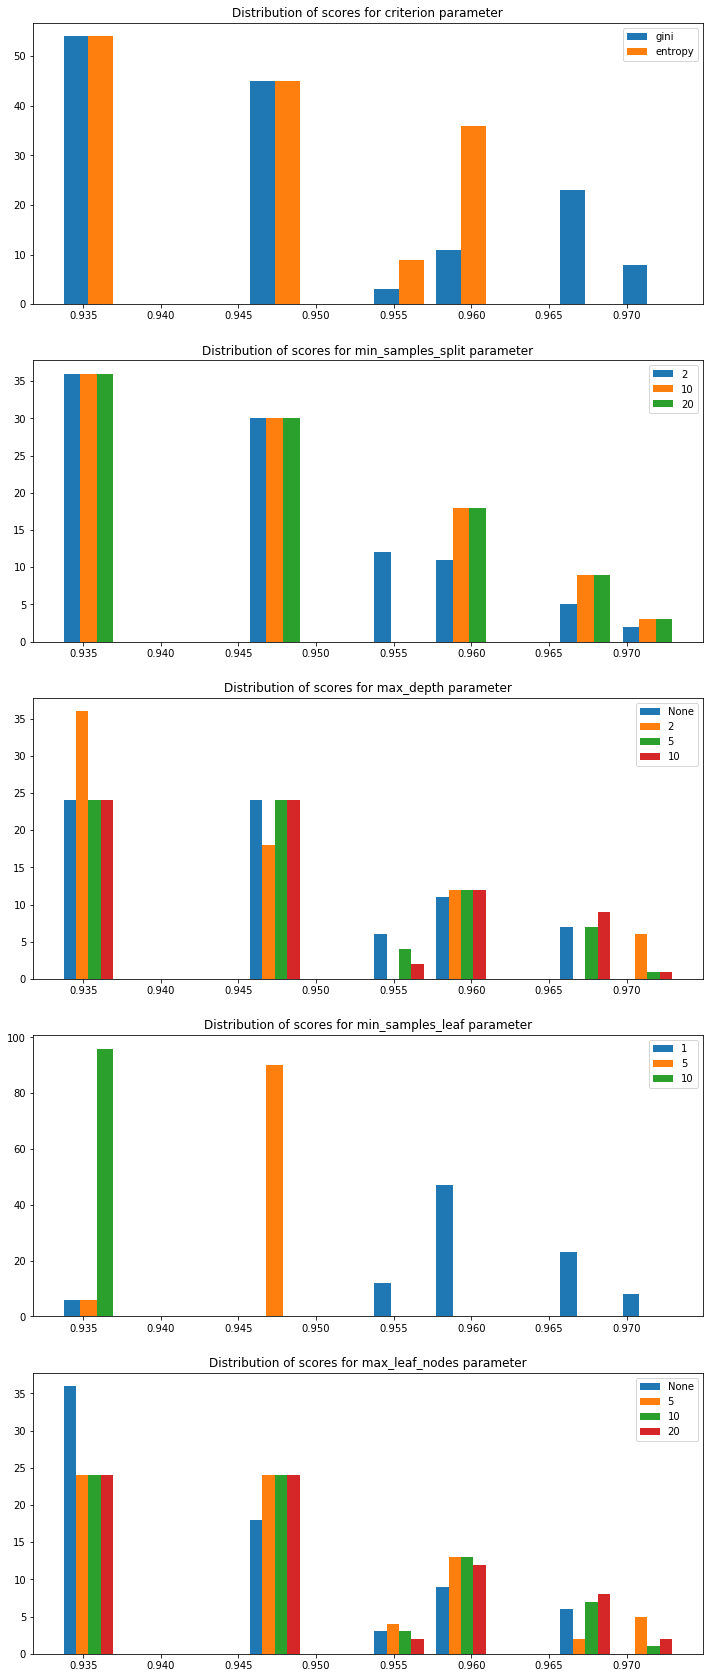

In [22]:
gs = get_gridsearch(clf,gs_params,5,1)
plot_grid_search_distribution(gs)

From the charts:
  * We should choose `max_leaf_nodes` to be `20`. Increasing the parameter further might give better results.
  * We should choose `min_samples_leaf` to be `1`
  * Higher values seem to produce better results for `min_samples_split`. Split on two cases may cause overfitting. There doesn't seem to be much difference in performance from setting this to `10` or `20`.
  * Allowing the tree to be deeper appears to give better results. We'll set `max_depth` to `None`becuase this gives slightly better accuracy than `10` overall.
  * The method used to split nodes, the `criterion` seems least clear, but `gini` seems to have an edge.
Now we've optimised parameters we can fit the tree on the whole set of data and see what difference the optimisation makes. 

In [8]:
#create optimised classifier
optclf = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_split=20, \
                                     min_samples_leaf=1,max_leaf_nodes=5)
optclf.fit(features,target)
scores = cross_validate(optclf,X=features,y=target,cv=10,verbose=True)
np.mean(scores['test_score'])

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.96666666666666656

So model accuracy improved 1.3%. We'll try a Random Forest model on the same data and compare performance

# Random Forest
From doing some research it seems that there are three parameters most likely to affect performance:
  * The number of trees `n_estimators`
  * The `criterion` that defines splits
  * The `max_features` that defines how many features to consider at each split

Again let's create a naive classifier to use as our baseline.

In [24]:
nveclf = RandomForestClassifier(random_state=0,max_features='sqrt')
scores = cross_val_score(nveclf,features,target,cv=10,verbose=True)
np.mean(scores)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.95999999999999996

We'll attempt to improve this score of 0.96 by tuning the tree. Clearly this is already quite a high score so any tuning may have minimal impact. We'll do a grid search and plot the mean scores from each parameter combination:
  * The `n_estimators` parameter we ideally want to be as high as possible as this increases the performance of the classifier, but makes the gridsearch and classifier slower.
  * We'll search across both `gini` and `entropy` criteria
  * We have 4 features so are limited to using either 2 or 3 of those as `max_features`. Using 4 would result in correlation across trees.
  * We have 150 samples in our dataset so the `min_samples_leaf` will have to be quite small, likewise for `min_samples_split`
  * We chose not to set the `max_depth` parameter as the `min_samples_split` works similarly to 'prune' the tree

In [28]:
gs_params = {'criterion': ['gini','entropy'],
         'max_features': [0.5,0.75], 
          'min_samples_leaf': [1,2,5],
         'min_samples_split': [2,5,10]}

clf = RandomForestClassifier(random_state=1,n_estimators=200)

We can see from the plots above that even using cross validation there is still a lot of random variation. We'll choose 200 for `n_estimators` as the mean score improves generally as the number of estimators rises. We'll do a gridsearch now across the other parameters using a range of random states.

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   31.7s finished


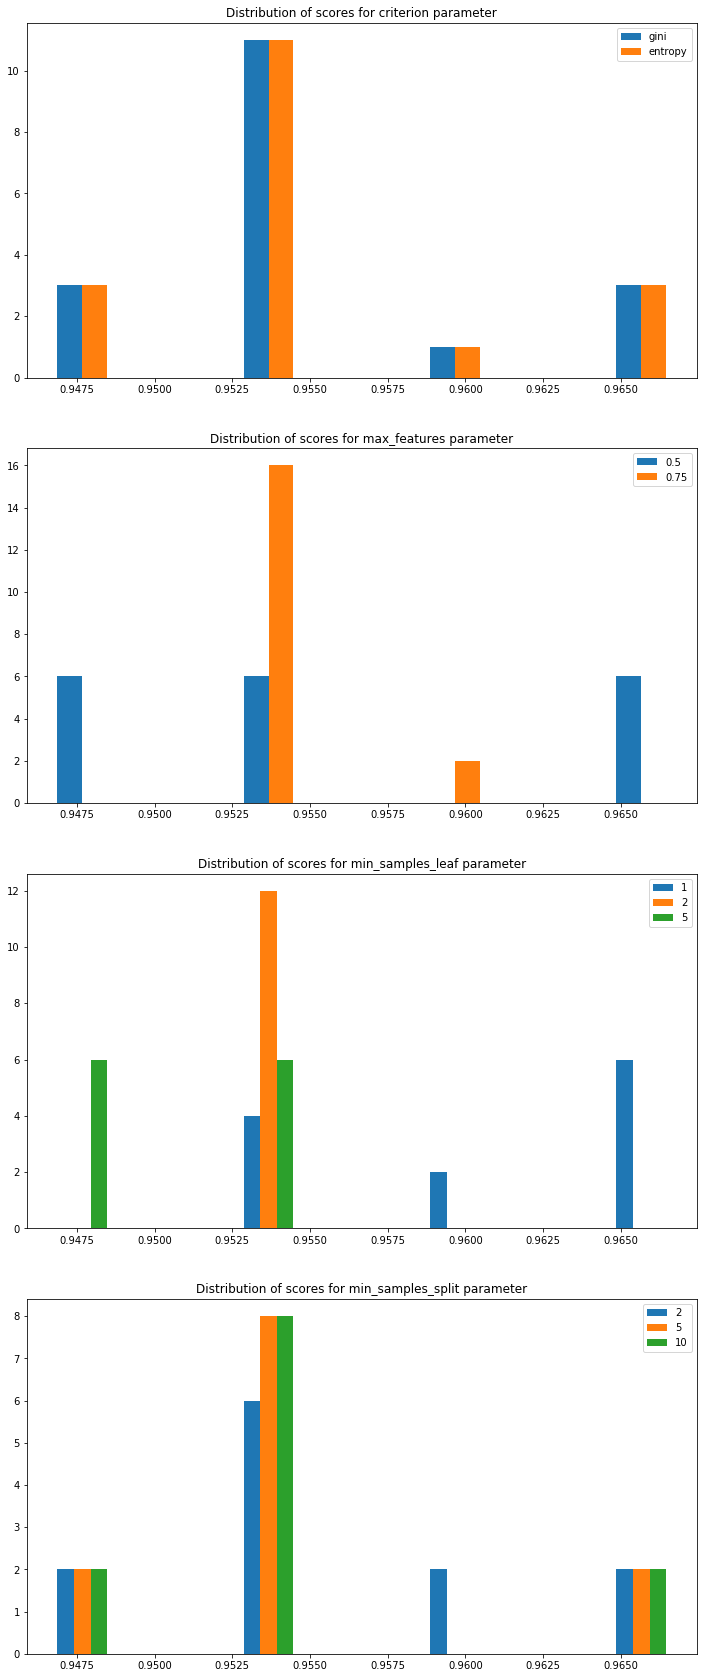

In [29]:
gs = get_gridsearch(clf,gs_params,5,1)
plot_grid_search_distribution(gs)

In [35]:
#create optimised classifier
optclf = RandomForestClassifier(criterion='entropy',max_features=0.75,min_samples_split=2, \
                                     min_samples_leaf=1)
optclf.fit(features,target)
scores = cross_validate(optclf,X=features,y=target,cv=10,verbose=True)
np.mean(scores['test_score'])

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.96666666666666656

In this case we can see accuracy is slighlty by using the RF model. Running the same code above repeatedly gives a range of results due to the stochastic nature. We can conlclude the decision tree is an effective model for this data with minimal overhead, and in fact parameter tuning gives a small increase in accuracy.